## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
#!pip install q hyperopt

In [3]:
%matplotlib inline

In [4]:
# для математических вычислений
import numpy as np

# для работы с таблицами
import pandas as pd

# для EDA анализа
import ydata_profiling

# для визуализации
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# для разбивки данных на выборки
from sklearn.model_selection import train_test_split

# константная модель
from sklearn.dummy import DummyRegressor

# для расчёта качества моделей
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# модели машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# для реализации градиентного бустинга
import lightgbm as lgb

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для расчёта времени выполнения кода
import time

## 2 Открытие файла с данными и их анализ
Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`, выполнив ресемплирование по одному часу. После проведём EDA анализ.

In [38]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv', index_col=[0], parse_dates=[0])
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv', index_col=[0], parse_dates=[0])
    
    df = df.resample('1H').sum()
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

In [39]:
df = read_eda('taxi')

[Посмотреть анализ.](https://www.dropbox.com/s/tzkaxe62o1wejg7/taxi.html?dl=0)

**Проблем не обнаружено.**

Построим график временного ряда.

In [8]:
FIGSIZE_PLOT = (15, 5)
TITLE_FONTSIZE = 18
LABELS_FONTSIZE = 14

def title_labels(title='временного ряда'):
    plt.xlabel('Временной ряд, часы', fontsize=LABELS_FONTSIZE)
    plt.ylabel('Количество заказов', fontsize=LABELS_FONTSIZE)
    plt.title('График ' + title, fontsize=TITLE_FONTSIZE)
    plt.show()

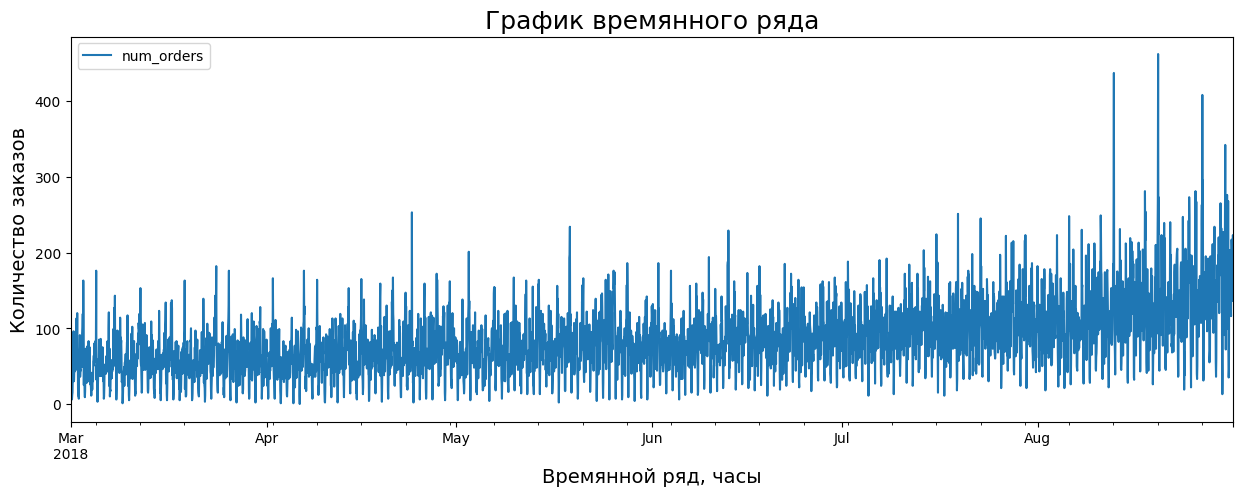

In [9]:
df.plot(figsize=FIGSIZE_PLOT)
title_labels()

Разложим временной ряд на тренд и сезонную компоненту, построим графики.

In [10]:
FIGSIZE_SUBPLOTS = (10, 9)

def subplot(num, title):
    plt.subplot(num)
    plt.title(title, fontsize=LABELS_FONTSIZE)

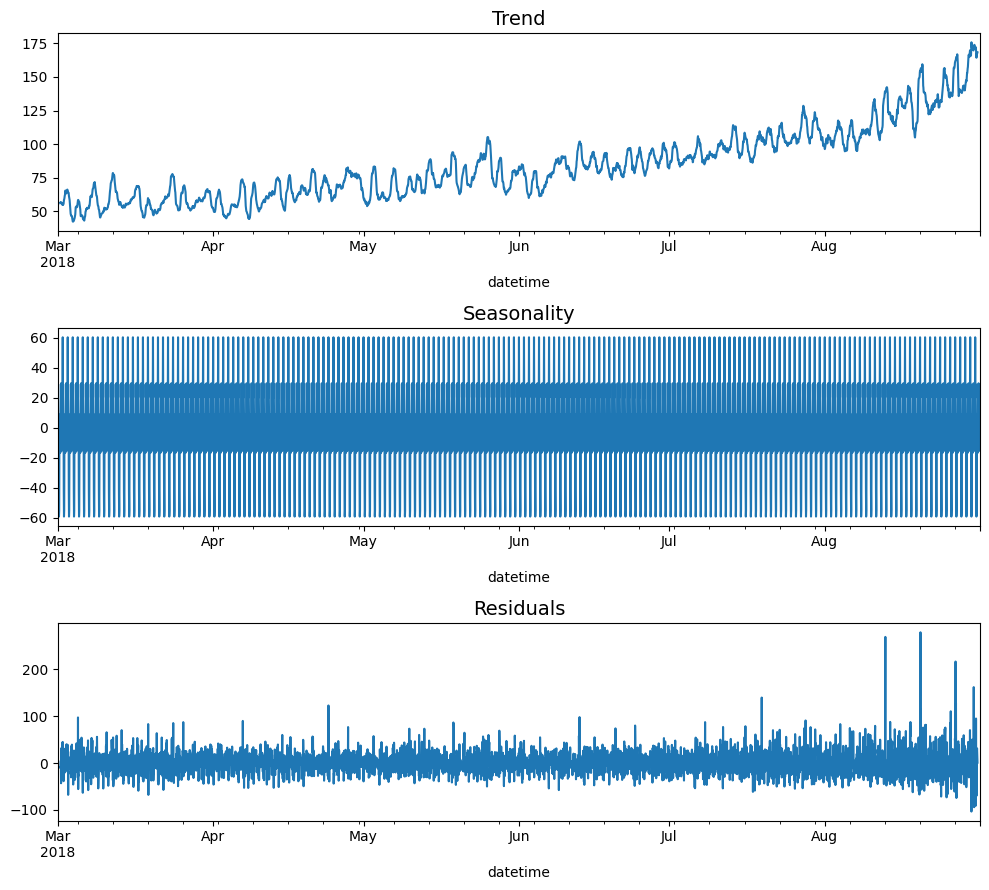

In [11]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=FIGSIZE_SUBPLOTS)
subplot(311, 'Trend')
decomposed.trend.plot(ax=plt.gca())
subplot(312, 'Seasonality')
decomposed.seasonal.plot(ax=plt.gca())
subplot(313, 'Residuals')
decomposed.resid.plot(ax=plt.gca())
plt.tight_layout()

- **Присутствует восходящий тренд, не зависящий от времени года.**
- **Что касается сезонности, закономерностией не разглядеть, визуализируем 2 дня.**

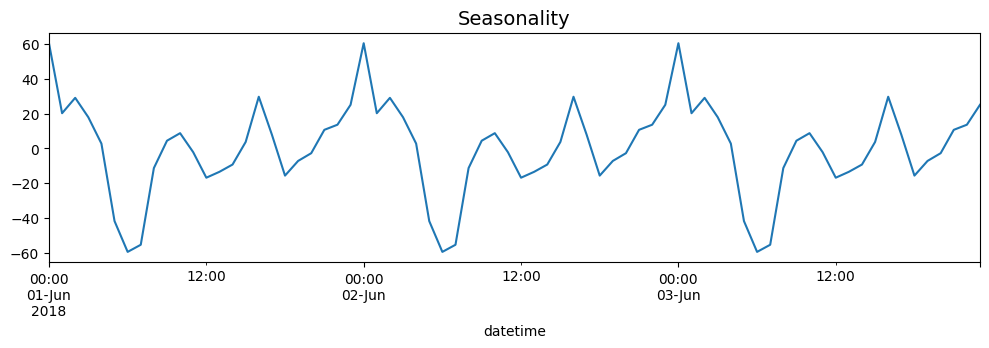

In [12]:
plt.figure(figsize=FIGSIZE_SUBPLOTS)
subplot(312, 'Seasonality')
decomposed.seasonal["2018-06-01":"2018-06-03"].plot(ax=plt.gca())
plt.tight_layout()

**Закономерности повторяются примерно каждые сутки.**

Снизим колебания во временном ряду, применив скользящее среднее, найдём скользящее стандартное отклонение и построим график.

In [13]:
WINDOW = 48
new_df = df.copy()

def rolling_mean_std():
    new_df['mean'] = new_df['num_orders'].rolling(WINDOW).mean() 
    new_df['std'] = new_df['num_orders'].rolling(WINDOW).std() 
    new_df.plot(figsize=FIGSIZE_PLOT, color=['lightblue', 'red', 'purple'])
    title_labels()

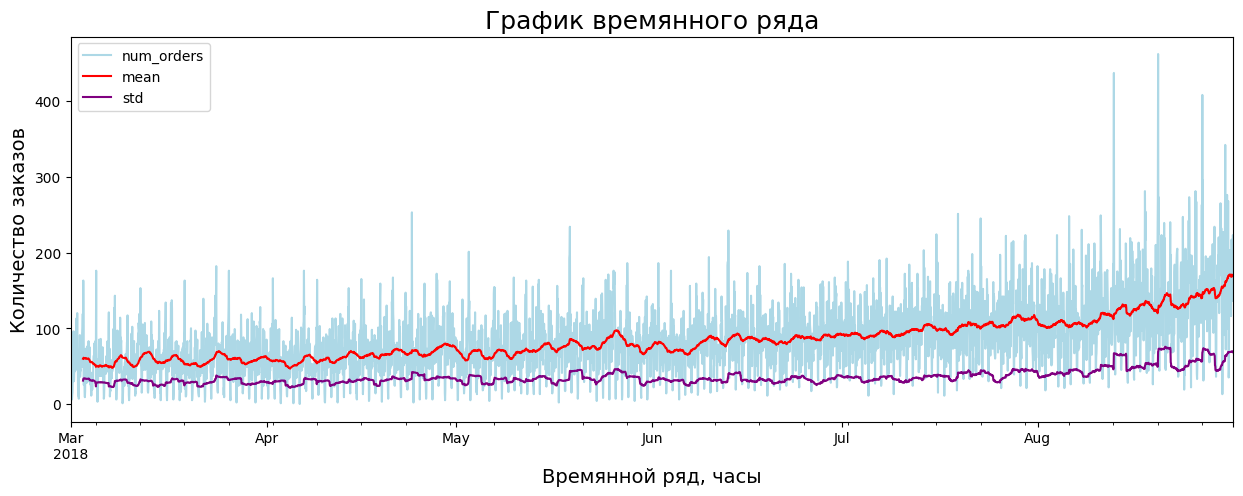

In [14]:
rolling_mean_std()

Проверим ряд на стационарность, найдя разности его значений.

In [15]:
new_df['num_orders'] = new_df['num_orders'] - new_df['num_orders'].shift()

Найдём скользящее среднее и скользящее стандартное отклонение нового датафрейма и изобразим на графике.

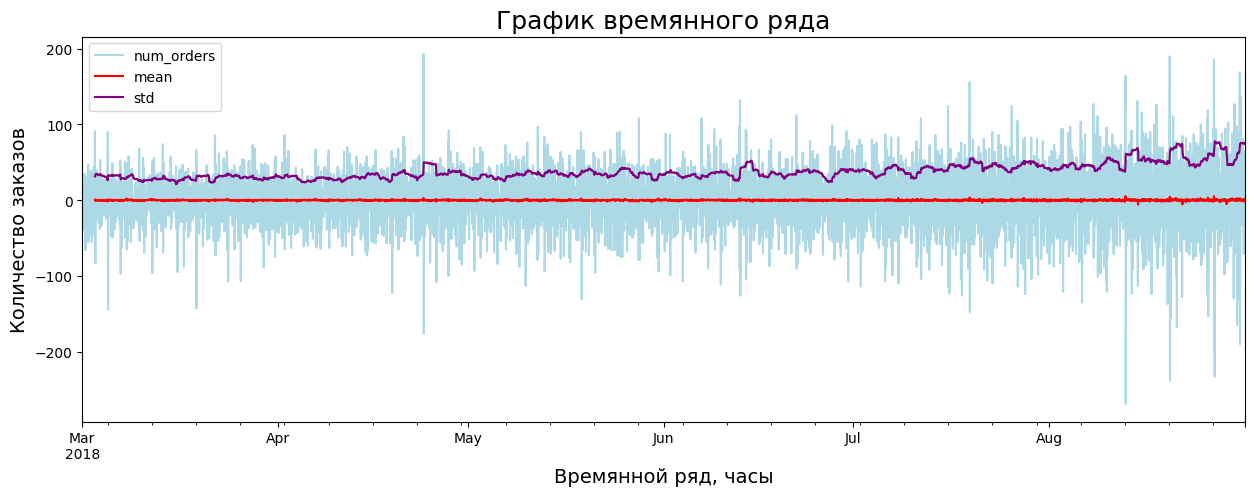

In [16]:
rolling_mean_std()

**Ряд стал более стационарным, значит, его можно прогнозировать.**

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты анализа данных:</b>
        <ol>
        <li>Проблем в данных не обнаружено;</li>
        <li>Присутствует восходящий тренд, не зависящий от времени года;</li>
        <li>Что касается сезонности, закономерности повторяются примерно каждые сутки.</li>
        <li>Времянной ряд стал более стационарным после нахождения разности его значений, значит, его можно прогнозировать.</li>
        </ol>
   </p>  
</div>

## 3 Работа с моделями
Напишем функцию для получения выборок с созданными признаками.

In [17]:
RANDOM_STATE = 0

def get_samples(max_lag, rolling_mean_size):
    def xy(df):
        x = df.drop('num_orders', axis=1)
        y = df['num_orders']
        return x, y
    
    end_df = pd.DataFrame(index=df.index)
    end_df['num_orders'] = df['num_orders']
    
    end_df['year'] = df.index.year
    end_df['month'] = df.index.month
    end_df['day'] = df.index.day
    end_df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        end_df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    end_df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(end_df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
    train = train.dropna()
    
    x_train, y_train = xy(train)
    x_test, y_test = xy(test)
    return x_train, y_train, x_test, y_test

Пока не будем подбирать параметры для функции, впишем размер сезонной периодичности.

In [18]:
x_train, y_train, x_test, y_test = get_samples(24, 24)

### 3.1 Обучение
Обучим разные модели без гиперпараметров и выберем лучшую.

In [19]:
def rmse(y, pred):
    return mean_squared_error(y, pred, squared=False)

In [20]:
def quality(mdl, return_qual=0, print_qual=1):
    scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring=make_scorer(rmse, greater_is_better=False))
    quality = -scores.mean()
    
    if print_qual == 1:
        print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [21]:
%%time
quality(LinearRegression())

Качество: 25.865263828973923
CPU times: total: 78.1 ms
Wall time: 58.8 ms


In [22]:
%%time
quality(RandomForestRegressor(random_state=RANDOM_STATE))

Качество: 24.528819792681634
CPU times: total: 50.7 s
Wall time: 51 s


In [23]:
%%time
quality(lgb.LGBMRegressor())

Качество: 24.214592651419828
CPU times: total: 2.31 s
Wall time: 647 ms


**По соотношению времени и качества выделяются градиентный бустинг, подберём для него гиперпараметры.**

### 3.2 Подбор гиперпараметров
Для подбора будем использовать байесовскую оптимизацию.

In [24]:
state = np.random.default_rng(RANDOM_STATE)

def hp_slctns(model, space):
    def func(args):
        mdl = model.set_params(**args)
        scores = cross_val_score(mdl, x_train, y_train, cv=TimeSeriesSplit(n_splits=5), 
                                 scoring=make_scorer(rmse, greater_is_better=False), error_score='raise')
        final_score = -sum(scores) / len(scores)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [25]:
lgb_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 2)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 100, 500, 2)), 
    'max_depth': scope.int(hp.quniform('max_depth', 100, 500, 2)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0), 
    'reg_alpha': hp.loguniform('reg_alpha', -16, 5), 
    'reg_lambda': hp.loguniform('reg_lambda', -16, 5)
}

best_lgb = hp_slctns(model=lgb.LGBMRegressor(), space=lgb_space)

100%|█████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.76s/trial, best loss: 25.76223785213662]
Лучшие гиперпараметры: {'learning_rate': 0.027944462244889345, 'max_depth': 234.0, 'n_estimators': 250.0, 'num_leaves': 264.0, 'reg_alpha': 0.28905009882936405, 'reg_lambda': 0.0012128766028278947}


### 3.3 Подбор ширины окна и максимального размера отставания
Переберём в цикле параметры и запишем их и качество моделей в датафрейм.

In [27]:
params = pd.DataFrame(columns=['Отставание', 'Окно', 'Качество'])
for max_lag in range(40, 50):
    for rolling_mean_size in range(40, 50):
        x_train, y_train, x_test, y_test = get_samples(max_lag, rolling_mean_size)
        params.loc[params.shape[0]] = [max_lag, rolling_mean_size, 
                                       quality(best_lgb, print_qual=0, return_qual=1)]

Построим график с качеством.

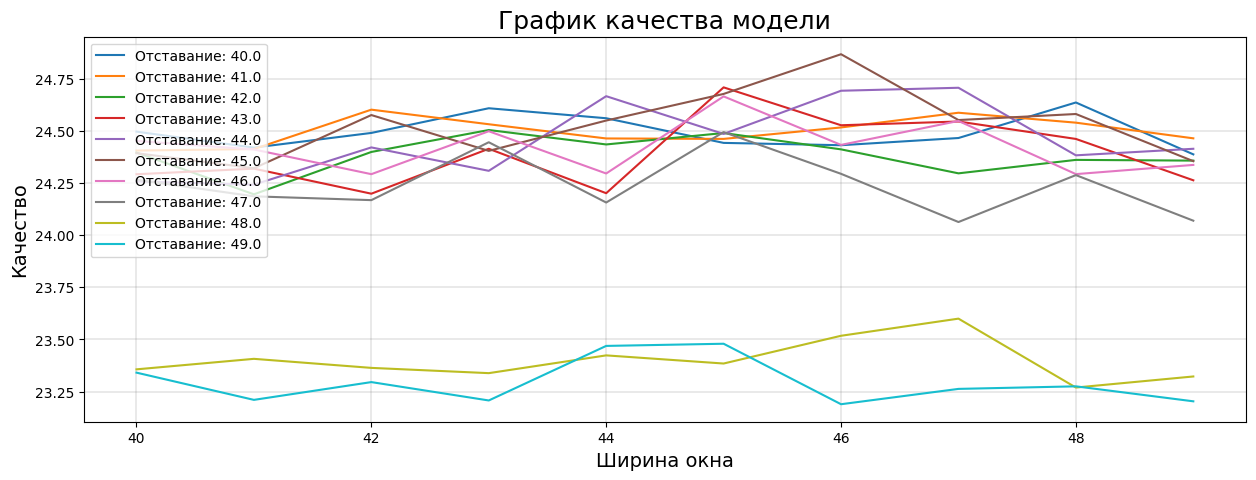

In [28]:
_, ax = plt.subplots(figsize=FIGSIZE_PLOT)

for lag in params['Отставание'].unique():
    tmp = params.loc[params['Отставание']==lag]
    ax.plot(tmp['Окно'], tmp['Качество'], label=f"Отставание: {lag}")
ax.grid(color='grey', lw=0.25)
ax.set_xlabel('Ширина окна', fontsize=LABELS_FONTSIZE)
ax.set_ylabel('Качество', fontsize=LABELS_FONTSIZE)
ax.set_title('График качества модели', fontsize=TITLE_FONTSIZE)
ax.legend(loc='upper left')
plt.show()

Получим лучшие значения параметров и вставим их в функцию создания выборок.

In [29]:
best_lag = int(params.loc[params[['Качество']].idxmin(), 'Отставание'])
best_rol = int(params.loc[params[['Качество']].idxmin(), 'Окно'])

x_train, y_train, x_test, y_test = get_samples(best_lag, best_rol)

### 3.4 Сравнение с константной моделью
Получим RMSE константной модели.

In [30]:
dummy_mean = quality(DummyRegressor(strategy='mean'), return_qual=1)
dummy_median = quality(DummyRegressor(strategy='median'), return_qual=1)

Качество: 40.126462754471405
Качество: 40.109277705902386


Сохраним результаты лучшей константной модели в таблицу.

In [31]:
results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
results_df.loc['Константная модель'] = [dummy_median, 0, 0]

Получим строку с  градиентным бустингом.

In [32]:
def save_time(model, best_model, name):
    mdl = model.set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(x_train, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    pred = mdl.predict(x_test)
    score = rmse(y_test, pred)
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc[name] = [score, stop_train_timer, stop_pred_timer]
    
    return pred

In [33]:
pred = save_time(model=lgb.LGBMRegressor(), best_model=best_lgb, name='Градиентный бустинг')

Рассмотрим получившеюся таблицу.

In [34]:
results_df

,Качество,Время обучения,Скорость предсказания
Константная модель,40.109278,0.000000,0.000000
Градиентный бустинг,41.703941,1.718402,0.005984


**Модель превзошла костантную модель и её RMSE соответствует заявленным требованиям.**

### 3.5 Анализ
Построим график прогноз-факт.

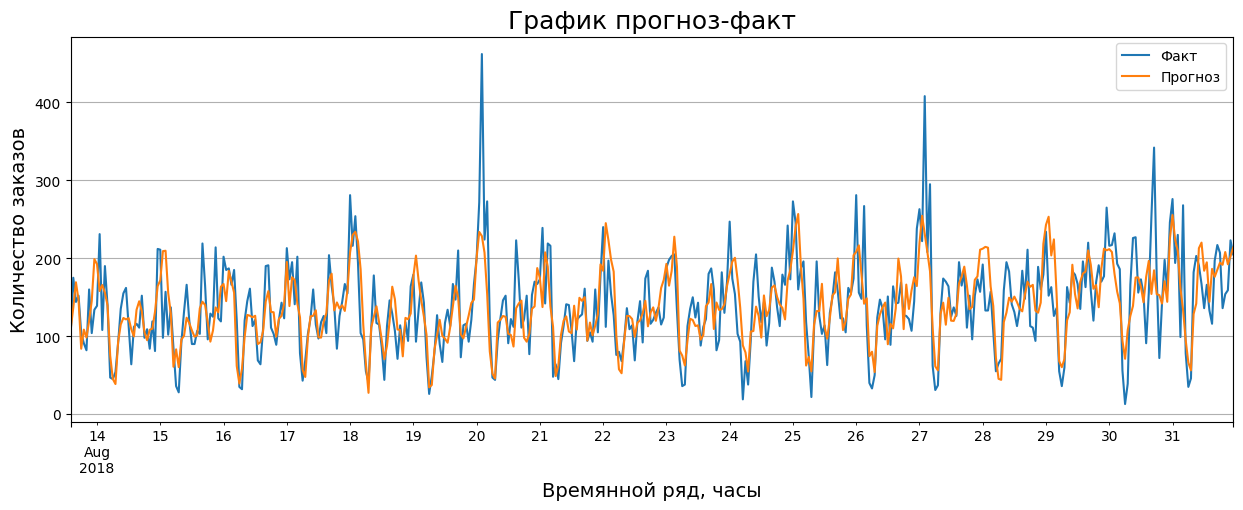

In [35]:
results = pd.concat([y_test, pd.Series(pred, index=y_test.index)], axis=1)
results.columns = ['Факт', 'Прогноз']
results.plot(figsize=FIGSIZE_PLOT, grid=True)
title_labels(title='прогноз-факт')

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке, её RMSE соответствует заявленным требованиям.</li>
        <li>Проведён анализ предсказания.</li>
        </ol>
   </p>  
</div>

## 4 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">

### Описание ключевых шагов решения
1. При исследовании данных было выявлено следующее:
   - Проблемы в данных отсутствуют;
   - Присутствует восходящий тренд, не зависящий от времени года;
   - Что касается сезонности, закономерности повторяются примерно каждые сутки.
   - Времянной ряд стал более стационарным после нахождения разности его значений, значит, его можно прогнозировать.
1. Были обучены разные модели и выбрана лучшая.
1. Лучшая модель была сравнена с константной и протестирована на тестовой выборке.
1. Был проведён анализ предсказания.

***

### Описание модели
Модель — `LGBMRegressor`.

Гиперпараметры:
- `random_state` = 0
- `learning_rate` = 0.04531853140527542
- `max_depth` = 380
- `n_estimators` = 368
- `num_leaves` = 476
- `reg_alpha` = 2.2897674399185596e-07
- `reg_lambda` = 3.2081956792213896e-06

***

### Итоговая метрика
RMSE 40.835502	

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">